In the [previous post](/posts/total-variation/), I showed how to use Moreau-Yosida regularization for inverse problems with non-smooth regularization functionals.
Specifically, we were looking at the total variation functional

$$R(q) = \alpha\int_\Omega|\nabla q|dx$$

as a regularizer, which promotes solutions that are piecewise constant on sets with relatively nice-looking boundary curves.
Rather than try to minimize this functional directly, we instead used a smooth approximation, which in many cases is good enough.
The smooth approximation is based on penalty-type methods, and one distinct disadvantage of penalty methods is that they tend to wreck the conditioning of the problem.
This poor conditioning manifests itself as a multiple order-of-magnitude imbalance in the different terms in the objective.
To minimize the objective accurately, say through a line search procedure, you have to do so with an accuracy that matches the magnitude of the smallest term.

In another previous post on [Nitsche's method](/posts/nitsches-method/), I looked at how the pure quadratic penalty method compared to the *augmented Lagrangian* method for imposing Dirichlet boundary conditions.
Here we'll proceed in a similar vein: what happens if we go from using a pure penalty method to using an augmented Lagrangian scheme?

### Generating the exact data

We'll use the exact same problem as in the previous post on total variation regularization -- a random Fourier series for the boundary data, a quadratic blob for the forcing, and a discontinuous conductivity coefficient.

In [1]:
import firedrake
mesh = firedrake.UnitSquareMesh(32, 32, diagonal='crossed')
Q = firedrake.FunctionSpace(mesh, 'CG', 2)
V = firedrake.FunctionSpace(mesh, 'CG', 2)

In [2]:
import numpy as np
from numpy import random, pi as π
x = firedrake.SpatialCoordinate(mesh)

rng = random.default_rng(seed=1)
def random_fourier_series(std_dev, num_modes, exponent):
    from firedrake import sin, cos
    A = std_dev * rng.standard_normal((num_modes, num_modes))
    B = std_dev * rng.standard_normal((num_modes, num_modes))
    return sum([(A[k, l] * sin(π * (k * x[0] + l * x[1])) +
                 B[k, l] * cos(π * (k * x[0] + l * x[1])))
                / (1 + (k**2 + l**2)**(exponent/2))
                for k in range(num_modes)
                for l in range(int(np.sqrt(num_modes**2 - k**2)))])

In [3]:
from firedrake import interpolate, project
g = interpolate(random_fourier_series(1.0, 6, 1), V)

In [4]:
from firedrake import inner, max_value, conditional, Constant
a = -Constant(4.5)
r = Constant(1/4)
ξ = Constant((0.4, 0.5))
q_true = interpolate(a * conditional(inner(x - ξ, x - ξ) < r**2, 1, 0), Q)

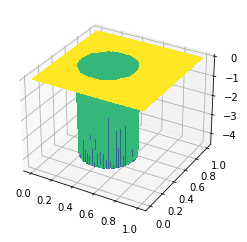

In [5]:
firedrake.trisurf(q_true);

In [6]:
b = Constant(6.)
R = Constant(1/4)
η = Constant((0.7, 0.5))
f = interpolate(b * max_value(0, 1 - inner(x - η, x - η) / R**2), V)

In [7]:
from firedrake import exp, grad, dx, ds
k = Constant(1.)
h = Constant(10.)
u_true = firedrake.Function(V)
v = firedrake.TestFunction(V)
F = (
    (k * exp(q_true) * inner(grad(u_true), grad(v)) - f * v) * dx +
    h * (u_true - g) * v * ds
)

In [8]:
opts = {
    'solver_parameters': {
        'ksp_type': 'preonly',
        'pc_type': 'lu',
        'pc_factor_mat_solver_type': 'mumps',
    },
}
firedrake.solve(F == 0, u_true, **opts)

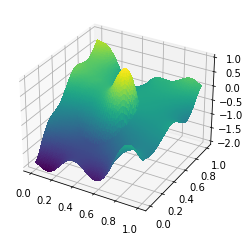

In [9]:
firedrake.trisurf(u_true);

### Generating the observational data

To create the synthetic observations, we'll once again need to call out directly to PETSc to get a random field with the right error statistics when using a higher-order finite element approximation.

In [10]:
ξ = firedrake.Function(V)
n = len(ξ.dat.data_ro)
ξ.dat.data[:] = rng.standard_normal(n)

In [11]:
from firedrake import assemble
from firedrake.petsc import PETSc
ϕ, ψ = firedrake.TrialFunction(V), firedrake.TestFunction(V)
m = inner(ϕ, ψ) * dx
M = assemble(m, mat_type='aij').M.handle
ksp = PETSc.KSP().create()
ksp.setOperators(M)
ksp.setUp()
pc = ksp.pc
pc.setType(pc.Type.CHOLESKY)
pc.setFactorSolverType(PETSc.Mat.SolverType.PETSC)
pc.setFactorSetUpSolverType()
L = pc.getFactorMatrix()
pc.setUp()

In [12]:
area = assemble(Constant(1) * dx(mesh))

In [13]:
z = firedrake.Function(V)
z.dat.data[:] = rng.standard_normal(n)
with z.dat.vec_ro as Z:
    with ξ.dat.vec as Ξ:
        L.solveBackward(Z, Ξ)
        Ξ *= np.sqrt(area / n)

In [14]:
û = u_true.dat.data_ro[:]
signal = û.max() - û.min()
signal_to_noise = 50
σ = firedrake.Constant(signal / signal_to_noise)

u_obs = u_true.copy(deepcopy=True)
u_obs += σ * ξ

### Solution via ADMM

To motivate ADMM, it helps to understand the augmented Lagrangian method.
There are two basic ways to solve equality-constrained optimization problems: the Lagrange multiplier method and the penalty method.
The augmented Lagrangian method uses both a Lagrange multiplier and a quadratic penalty, which astonishingly works much better than either the pure Lagrange multiplier or penalty methods.
ADMM is based on using the augmented Lagrangian method with a consensus constraint to split out non-smooth problems.
Specifically, we want to find a minimizer of the functional

$$J(q) = E(G(q) - u^o) + \alpha\int_\Omega|\nabla q|\, dx$$

where $E$ is the model-data misfit and $G$ is the solution operator for the problem

$$F(u, q) = 0.$$

If $F$ is continuously differentiable with respect to both of its arguments and the linearization with respect to $u$ is invertible, then the implicit function theorem in Banach spaces tells us that such a solution operator $u = G(q)$ exists.
Minimizing this functional $J(q)$ is more challenging than the case where we used the $H^1$-norm to regularize the problem because the total variation functional is non-smooth.
In the previous post, we showed how to work around this challenge by using Moreau-Yosida regularization.
You can motivate Moreau-Yosida regularization by introducing an auxiliary vector field $v$ and imposing the constraint that $v = \nabla q$ by a quadratic penalty method.
We can then solve for $v$ exactly because we know analytically what the proximal operator for the 1-norm is.
The resulting functional upon eliminating $v$ is the Moreau-Yosida regularized form.

The idea behind ADMM is to instead use an augmented Lagrangian -- combining both the classical method of Lagrange multipliers with the quadratic penalty method -- to enforce the constraint that $v = \nabla q$.
This gives us the augmented Lagrangian

$$\begin{align}
L_\rho(q, v, \mu) & = E(G(q) - u^o) + \alpha\int_\Omega|v|\, dx \\
& \qquad + \rho\alpha^2\int_\Omega\left(\mu\cdot(\nabla q - v) + \frac{1}{2}|\nabla q - v|^2\right)dx.
\end{align}$$

If you've seen ADMM before, you might notice that we've scaled the penalty parameter a bit.
We put in an extra factor of $\alpha^2$ with the penalty term $\|\nabla q - v\|^2$ and an extra factor of $\rho\alpha^2$ with the Lagrange multiplier $\mu$ so that it has the same units as both $\nabla q$ and $v$.
In order to highlight the connection with Moreau-Yosida regularization, we'll do a slight rearrangement by completing the square:

$$\begin{align}
L_\rho(q, v, \mu) & = E(G(q) - u^o) + \alpha\int_\Omega|v|\, dx \\
& \qquad + \frac{\rho\alpha^2}{2}\int_\Omega\left\{|\nabla q + \mu - v|^2 - |\mu|^2\right\}dx.
\end{align}$$

If we look at the parts of the Lagrangian involving only $v$, we get something that looks a lot like Moreau-Yosida regularization of the $L^1$ norm, only the argument to be evaluated at is $\nabla q + \mu$.
Likewise, if we look at the parts of the Lagrangian involving only $q$, we have something that looks exactly like $H^1$ regularization, only with the regularization centered around $v - \mu$ instead of around 0.

Each iteration of the method will proceed in three steps:

1. Minimize $L_\rho$ with respect to $q$ only.
This step is very similar to using the squared $H^1$-norm for regularization but for the fact that we're not regularizing around 0, but rather around $v - \mu$.
2. Minimize $L_\rho$ with respect to $v$:
$$v \leftarrow \text{soft threshold}_{\rho\alpha}(\nabla q + \mu)$$
3. Perform a gradient ascent step for $\mu$:
$$\mu \leftarrow \mu + \nabla q - v$$

The final gradient ascent step for $\mu$ seemed a little bit mysterious to me at first.
Ultimately the whole problem is a saddle point problem for $\mu$, so intuitively it made sense to me that gradient ascent would move you in the right direction.
I still felt in my gut that you should have to do some more sophisticated kind of update for $\mu$.
So I fell down a deep rabbit hole trying to understanding why the augmented Lagrangian method actually works.
The usual references like Nocedal and Wright are deafeningly silent on this issue; the only source I could find that gave a decent explanation was [Nonlinear Programming](http://www.athenasc.com/nonlinbook.html) by Bertsekas.
You could just believe me that step 3 is the right thing to do, but the reasons why are not at all trivial!

In [15]:
from firedrake_adjoint import (
    Control,
    ReducedFunctional,
    minimize,
)

First, we'll solve the forward problem with our blunt initial guess for the solution.
Under the hood, pyadjoint will tape this operation, thus allowing us to correctly calculate the derivative of the objective functional later.

In [16]:
q = firedrake.Function(Q)
u = firedrake.Function(V)
F = (
    (k * exp(q) * inner(grad(u), grad(v)) - f * v) * dx +
    h * (u - g) * v * ds
)
forward_problem = firedrake.NonlinearVariationalProblem(F, u)
forward_solver = firedrake.NonlinearVariationalSolver(forward_problem, **opts)
forward_solver.solve()

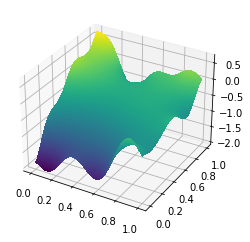

In [17]:
firedrake.trisurf(u);

These variables will store the values of the auxiliary field $v$ and the multiplier $\mu$ that enforces the constraint $v = \nabla q$.
An interesting question that I haven't seen addressed anywhere in the literature on total variation regularization is what finite element basis to use for $v$ and $\mu$.
Here we're using the usual continuous Lagrange basis of degree 1, which seems to work.
I've also tried this with discontinuous basis functions and hte estimates for $v$ and $\mu$ seem to have oscillatory garbage.
I have a hunch that some bases won't work because they fail to satisfy the [LBB](https://en.wikipedia.org/wiki/Ladyzhenskaya%E2%80%93Babu%C5%A1ka%E2%80%93Brezzi_condition) conditions.
I have another hunch that it would be fun to repeat this experiment with some kind of H(curl)-conforming element for $v$ and $\mu$, but for now we'll just stick with CG(1).

In [18]:
Δ = firedrake.VectorFunctionSpace(mesh, 'CG', 1)
v = firedrake.Function(Δ)
μ = firedrake.Function(Δ)

At first, $v$ and $\mu$ are zero.
So when we start the iteration, the first value of $q$ that we'll compute is just what we would have found had we used $H^1$-regularization.
We'll start with the ADMM penalty of $\rho = 1$ and we'll use the same regularization penalty of $\alpha = 1 / 20$ that we used in the previous demo.

In [19]:
α = Constant(5e-2)
ρ = Constant(1.0)

Next we'll execute a few steps of the ADMM algorithm.
I picked the number of iterations out of a hat.
You should use an actual stopping criterion if you care about doing this right.

In [20]:
from firedrake import sqrt
import tqdm

qs = [q.copy(deepcopy=True)]
vs = [v.copy(deepcopy=True)]
μs = [μ.copy(deepcopy=True)]

num_steps = 15
for step in tqdm.trange(num_steps):
    # Step 1: Solve the inverse problem for q.
    J = assemble(
        0.5 * ((u - u_obs) / σ)**2 * dx +
        0.5 * ρ * α**2 * inner(grad(q) + μ - v, grad(q) + μ - v) * dx
    )

    q_opt = minimize(ReducedFunctional(J, Control(q)))
    q.assign(q_opt)
    forward_solver.solve()

    # Step 2: soft thresholding for v.
    z = grad(q) + μ
    expr = conditional(
        (ρ * α) ** 2 * inner(z, z) < 1,
        Constant((0, 0)),
        (1 - 1 / (ρ * α * sqrt(inner(z, z)))) * z
    )
    v.project(expr)
    
    # Step 3: gradient ascent for μ.
    μ.project(μ + grad(q) - v)
    
    qs.append(q.copy(deepcopy=True))
    vs.append(v.copy(deepcopy=True))

100%|██████████| 15/15 [23:25<00:00, 93.67s/it] 


The resulting computed value of $q$ does a great job capturing all of the sharp edges in $q$, despite the fact that we use a penalty parameter of $\rho = 1$.
When we used the pure penalty method in the previous demo, we had to take the penalty parameter to be on the order of 400.
The inverse solver took much longer to converge and we still missed some of the edges.

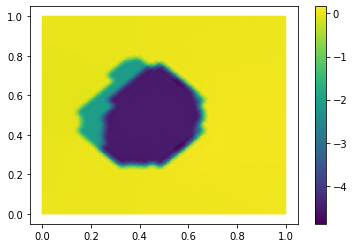

In [21]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
colors = firedrake.tripcolor(q, axes=axes)
fig.colorbar(colors);

The split variable $v$ matches the gradient of $q$ quite well.

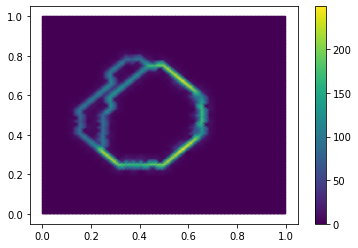

In [22]:
fig, axes = plt.subplots()
colors = firedrake.tripcolor(v, axes=axes)
fig.colorbar(colors);

Finally, let's look at the relative changes in successive iterates of $q$ in the 1-norm at each step in order to get an idea of how fast the method converges.

In [23]:
δs = [
    assemble(abs(q2 - q1) * dx) / assemble(abs(q2) * dx)
    for q1, q2 in zip(qs[:-1], qs[1:])
]

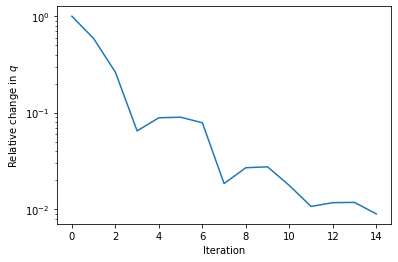

In [24]:
fig, axes = plt.subplots()
axes.set_yscale('log')
axes.set_ylabel('Relative change in $q$')
axes.set_xlabel('Iteration')
axes.plot(δs);

Some iterations seem to hardly advance the solution at all, but when taken in aggregate this looks like the typical convergence of a first-order method.

### Discussion

Much like the pure penalty method, the alternating direction method of multipliers offers a way to solve certain classes of non-smooth optimization problem by instead solving a sequence of smooth ones.
ADMM, by introducing an explicit Lagrange multiplier estimate to enforce the consensus constraint, offers much faster convergence than the pure penalty method and the size of the penalty parameter does not need to go off to infinity.
As a consequence, each of the smooth optimization problems that we have to solve has much better conditioning.

For this test case, we were able to take the penalty parameter $\rho$ to be equal to 1 from the outset and still obtain a good convergence rate.
For more involved problems it's likely that we would instead have to test for convergence with a given value of $\rho$ and increase it by some factor greater than 1 if need be.
Scaling this penalty parameter by an appropriate power of the regularization parameter $\alpha$ ahead of time makes it dimensionless.
This property is especially advantageous for realistic problems but it requires you to know something about the objective you're minimizing.

There are obvious grid imprinting artifacts in the solution that we computed.
To remedy this undesirable feature, we could use a mesh adaptation strategy that would refine (preferably anisotropically) along any sharp gradients in $q$.

Finally, we motivated ADMM by assuming that we could take an $L^2$-norm difference of $v$ and $\nabla q$.
The idealized, infinite-dimensional version of the problem assumes only that $q$ lives in the space $BV(\Omega)$ of functions of bounded variation.
The gradient of such a function is a finite, signed Borel measure, and thus may not live in $L^2$ at all.
[Hintermüller et al. (2014)](https://doi.org/10.1088/0266-5611/30/5/055014) gives an alternative formulation based on the dual problem, which has the right coercivity properties for Moreau-Yosida regularization to make sense.
It's possible that the form I presented here falls afoul of some subtle functional analysis and that the solutions exhibit strong mesh dependence under refinement.
Alternatively, it's possible that, while $v$ and $\nabla q$ only live in the space of finite signed measures and thus are not square integrable, their difference $\nabla q - v$ does live in $L^2$.
Investigating this more will have to wait for another day.